In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
""" Load CIFAR-10 dataset """
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [ ]:
""" Normalize pixel values """
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
""" Convert labels to one-hot encoding """
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

In [ ]:
""" Load the pre-trained VGG16 model without the top layers """
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

""" Freeze the pre-trained layers """
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
""" Data augmentation """
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

num = 10000

augmented_data = []
augmented_labels = []

for x_batch, y_batch in datagen.flow(train_images, train_labels, batch_size=num):
    augmented_data.extend(x_batch)
    augmented_labels.extend(y_batch)
    if len(augmented_data) >= num:
        break

x_train_concat = np.concatenate((train_images, augmented_data[:len(train_images)]))
y_train_concat = np.concatenate((train_labels, augmented_labels[:len(train_labels)]))

shuffle_idx = np.random.permutation(len(x_train_concat))
x_train_concat = x_train_concat[shuffle_idx]
y_train_concat = y_train_concat[shuffle_idx]

print(x_train_concat.shape, '|', y_train_concat.shape)

(60000, 32, 32, 3) | (60000, 10)


In [ ]:
""" Add custom top layers for CIFAR-10 classification """
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

""" Compile the model """
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
""" Early stopping callback """
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
""" Train the model """
history = model.fit(
    x_train_concat,
    y_train_concat,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
  )

Epoch 1/15
750/750 [==============================] - 55s 72ms/step - loss: 1.3894 - accuracy: 0.5157 - val_loss: 1.2563 - val_accuracy: 0.5617
Epoch 2/15
750/750 [==============================] - 54s 72ms/step - loss: 1.2007 - accuracy: 0.5818 - val_loss: 1.1987 - val_accuracy: 0.5807
Epoch 3/15
750/750 [==============================] - 54s 72ms/step - loss: 1.1411 - accuracy: 0.6004 - val_loss: 1.1728 - val_accuracy: 0.5929
Epoch 4/15
750/750 [==============================] - 54s 73ms/step - loss: 1.0927 - accuracy: 0.6168 - val_loss: 1.1346 - val_accuracy: 0.6008
Epoch 5/15
750/750 [==============================] - 54s 72ms/step - loss: 1.0537 - accuracy: 0.6304 - val_loss: 1.1223 - val_accuracy: 0.6072
Epoch 6/15
750/750 [==============================] - 53s 71ms/step - loss: 1.0164 - accuracy: 0.6459 - val_loss: 1.1240 - val_accuracy: 0.6081
Epoch 7/15
750/750 [==============================] - 53s 71ms/step - loss: 0.9824 - accuracy: 0.6563 - val_loss: 1.1070 - val_accuracy:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
""" Evaluate the model on the test set """
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

313/313 [==============================] - 12s 37ms/step - loss: 1.1138 - accuracy: 0.6107
Test loss: 1.1138358116149902
Test accuracy: 0.6107000112533569


In [ ]:
""" Classes Dictionary """
classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

(32, 32, 3)


Text(0.5, 1.0, 'class_number: 5 | class_name: dog')

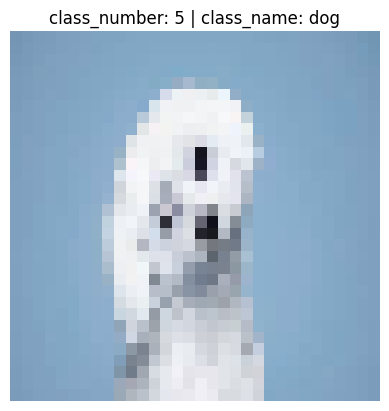

In [ ]:
""" Load a test image for predict """
import cv2

test_img = cv2.imread('dog.jpeg')
test_img = cv2.resize(test_img, (32, 32))

print(test_img.shape)
plt.imshow(test_img, 'Greys')
plt.axis('off')
plt.title("class_number: 5 | class_name: dog")

In [1]:
""" Prediction step """
test_img = test_img.reshape(-1, 32, 32, 3)
predicted_class = np.argmax(model.predict(test_img), axis=1)
print('predicted_class_number:', predicted_class)
print('predicted_class_name:', f'[{classes.get(predicted_class[0])}]')


predicted_class_number: [5]
predicted_class_name: [dog]


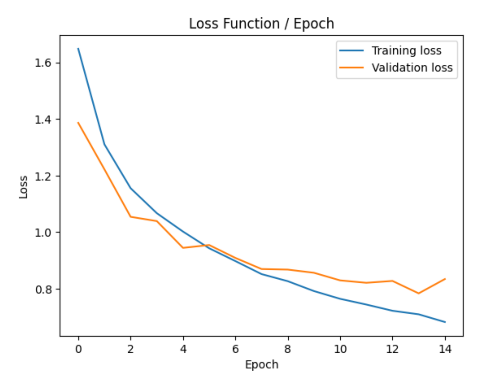

In [6]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss Function / Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

model.summary()

## THNAK YOU --- \\(^o^)/